In [120]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split as scikit_train_test_split
from surprise import Reader, Dataset, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, CoClustering, SlopeOne, SVDpp, NMF, BaselineOnly
from surprise.model_selection import KFold, RepeatedKFold, cross_validate, GridSearchCV, LeaveOneOut
from surprise.model_selection import train_test_split as surprise_train_test_split
import time

Data import:

In [133]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")

Data cleaning - Drop all categories which do not contain hard skills:

In [134]:
obsolete_categories = [
                "Betriebssystem",
                "Dienste",
                "Produkterfahrung",
                "Methoden und Praktiken",
                "Projektmanagement / Vorgehensmodelle",
                "Sprachen",
                "Einsatzfelder / Erfahrungen / Schwerpunkte",
                "Issue Management",
                "Branchenerfahrung",
                "Zertifizierung",
                "Beratung",
                "Agilität",
                "Tests",
                "Rolle (intern)",
                "nxp Abteilungen"
                ]

In [135]:
# df = df[~df["category"].isin(obsolete_categories)]

alle skills, die seltener als x mal vorkommen (zB x = 10) rausschmeiß0en


Declare various aiding variables

In [136]:
persons = df["person"].unique()
skills = sorted(df["skill"].unique())
categories = df["category"].unique()

In [137]:
employee_dict = {}
for n in range(1,len(persons)+1):
    employee_dict[n] = persons[n-1]

In [138]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Since this notebook demonstrates the a recommender system which deals with rated skills and the underlying data does not offer ratings, this measure will be implemented in the following way: 
- For each skill, the frequency of the underlying category will be measured. The skills will be rated according to this frequency 
- For example: If an employee has most skills in the category "Programmiersprachen", these skills will receive the highest rating

In [139]:
def scaler_1_5(x,old_max,old_min):
    old_range = (old_max - old_min)  
    if (old_range == 0):
        return 1
    else:
        new_range = (5 - 1) 
        x_std = (x - old_min)/(old_max-old_min)
        return round(x_std * new_range + 1)

In [140]:
# create dataframe for each employee and their category count
category_per_employee = pd.DataFrame(index=categories)
for p in persons:
    p_skills = df[df["person"] == p]
    # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    skill_values = np.array([])
    # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in categories:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
    category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

In [141]:
df_rated = pd.DataFrame()
for p in persons:
    # get employee
    df_subset = df[df["person"] == p].copy()
    # get skills of employee
    p_skills = df_subset["skill"].to_numpy()
    # initialize empty array for ratings
    ratings = np.zeros(len(p_skills))
    # fill array for each skill with respective category value 
    for i in range(0,len(p_skills)): 
        ratings[i] = category_per_employee.loc[category_dict[p_skills[i]]][p]
    # append ratings to subset and drop category column
    df_subset["rating"] = ratings
    df_subset.drop("category",axis=1,inplace=True)
    # append user to df
    df_rated = pd.concat([df_rated,df_subset],ignore_index=True)

In [142]:
df_rated.skill.nunique()

735

## Comparing Different Recommender Systems

Define holdout data: We want to take out 2 skills with high rating of 40% of users. Skills and users should be chosen randomly. 

BEDINGUNG; DASS SKILL; DIE NUR EINMAL VERTRETEN SIND NICHT ANGEFASST WERDEN

In [129]:
# specify how many datapoints should be stored in holdout (e. g. holdout_size = 0.1 -> 10% of datapoints will be put in holdout)
holdout_size = 0.1
# save original size of data for termination of while loop 
size_data = len(df_rated)
holdout = pd.DataFrame()
# get list which represents each employee with their number of entered skills in the data
employee_occurence = df_rated["person"].to_list()
# initialize random seed
seed = 0 
while len(holdout)/size_data < holdout_size:
    # randomly select employee (affected by how often they occur in the data)
    np.random.seed(seed)
    df_subset_emp = df_rated[(df_rated["person"] == np.random.choice(employee_occurence))]
    # if condition causes that employee do not get completely deleted from dataset
    if len(df_subset_emp) > 1:
        max_rating_emp = df_subset_emp["rating"].max()
        holdout_emp = df_subset_emp[df_subset_emp["rating"] == max_rating_emp].sample(n=1,random_state=seed)
        df_rated = df_rated.drop(holdout_emp.index)
        holdout = pd.concat([holdout,holdout_emp],ignore_index=True)
    # change seed for next while iteration
    seed = seed + 1

In [130]:
df_rated.skill.nunique()

724

In [12]:
# perc_users = 0.4
# n_skills = 2
# sample_size = int(np.ceil(len(persons)*perc_users))

# random.seed(1)
# sample = random.sample(population=persons.tolist(),k=sample_size)

# min_rating = 5

In [13]:
# holdout = pd.DataFrame()

# user_sample = []
# for person in sample: 
#     df_subset = df_rated[(df_rated["person"] == person) & (df_rated["rating"] >= min_rating)]
#     # try to get two random high ranking skills (if the employee doesn't have high ranking skills they will be skipped)
#     try:
#         holdout_employee = df_subset.sample(n=n_skills,random_state=1)
#         user_sample.append(person)
#         df_rated = df_rated.drop(holdout_employee.index)
#         holdout = pd.concat([holdout,holdout_employee],ignore_index=1)
#     except ValueError:
#         pass 
# holdout

In [149]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df_rated,reader)

In [15]:
NUM_TRIALS = 3
NUM_SPLITS = 5

In [16]:
def gridsearch_cv(algo_class,algo_name,param_grid,data,best_model_dict,best_params_dict):
    start = time.time()
    rmse = np.zeros(NUM_TRIALS)
    mse = np.zeros(NUM_TRIALS)
    mae = np.zeros(NUM_TRIALS)
    models = []
    params = []

    # hier eventuell gridsearch rein? 
    for i in range(NUM_TRIALS):
        print("Running CV for model", algo_name ,"in Iteration:", i ,"at", time.time()-start)
        cv = KFold(
                        n_splits=NUM_SPLITS,
                        random_state=i
                        # min_n_ratings=i
                    )
                        # COMMENT: min_n_ratings -> what's the impact of this parameter? 
        gs = GridSearchCV(
                        algo_class,
                        param_grid, 
                        measures=["rmse","mse","mae"], 
                        cv=cv,refit="rmse"
                    )
        gs.fit(data)
        rmse[i] = gs.best_score["rmse"]
        mse[i] = gs.best_score["mse"]
        mae[i] = gs.best_score["mae"]
        models.append(gs.best_estimator["rmse"])
        params.append(gs.best_params["rmse"])

    # hier noch erläutern, warum rmse als ausschlaggebene measure gewählt wird
    best_model_dict[algo_name] = models[np.argmin(rmse)]
    best_params_dict[algo_name] = params[np.argmin(rmse)]

    print("Total time: ", (time.time()-start), "sec.")
    return rmse, mse, mae 

In [17]:
def add_result(results, name, rmse, mse, mae):
    '''
    Function adding the results returned by nested_cv to a dataframe. 
    Results will be aggregated for better comparison. 
    Parameters: 

    Output:
    results DataFrame containing an additional row
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":rmse.mean(), 
        "rmse_std":rmse.std(), 
        "mse_mean":mse.mean(), 
        "mse_std":mse.std(), 
        "mae_mean":mae.mean(), 
        "mae_std":mae.std()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [1052]:
results = pd.DataFrame()
best_model_dict = {}
best_params_dict = {}

In [1053]:
algo_list = [
                (BaselineOnly,"Baseline",{
                                                "verbose":[False]
                                    }),
                (KNNBasic,"k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithMeans,"Centered k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (SVD,"SVD",{
                                                "n_factors": [40, 60, 80, 100, 120],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    }),
                (SVDpp,"SVD++",{
                                                "n_factors": [40, 60, 80, 100, 120],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "random_state":[1]
                                    }),
                (CoClustering,"CoClustering",{
                                                "n_cltr_u": [2, 3, 4],
                                                "n_cltr_i": [2, 3, 4],
                                                "n_epochs":[10, 20, 40, 60]
                                    }),
                (SlopeOne,"SlopeOne",{
                                    }),
                (NMF,"NMF",{
                                                "n_factors": [10, 15, 20, 40],
                                                "n_epochs": [20, 40, 80, 120],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    })
            ]

 N_FACTORS NOCH MAL REDUZIEREN
 

In [1054]:
for algo in algo_list:
    rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    results = add_result(results,algo[1],rmse, mse, mae)

Running CV for model Baseline in Iteration: 0 at 0.0
Running CV for model Baseline in Iteration: 1 at 0.20148015022277832
Running CV for model Baseline in Iteration: 2 at 0.380659818649292
Total time:  0.5626044273376465 sec.
Running CV for model k-NN in Iteration: 0 at 0.0
Running CV for model k-NN in Iteration: 1 at 19.19047713279724
Running CV for model k-NN in Iteration: 2 at 48.826831340789795
Total time:  83.7591814994812 sec.
Running CV for model Centered k-NN in Iteration: 0 at 0.0
Running CV for model Centered k-NN in Iteration: 1 at 39.24043536186218
Running CV for model Centered k-NN in Iteration: 2 at 78.11067008972168
Total time:  116.35114765167236 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 360.1125304698944
Running CV for model SVD in Iteration: 2 at 673.5810165405273
Total time:  984.7157893180847 sec.
Running CV for model SVD++ in Iteration: 0 at 0.0
Running CV for model SVD++ in Iteration: 1 at 7535.7263288497925
R

In [1055]:
best_params_dict

{'Baseline': {'verbose': False},
 'k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'Centered k-NN': {'k': 20, 'min_k': 1, 'verbose': False},
 'SVD': {'n_factors': 40,
  'n_epochs': 1000,
  'biased': False,
  'random_state': 1},
 'SVD++': {'n_factors': 40, 'n_epochs': 1000, 'random_state': 1},
 'CoClustering': {'n_cltr_u': 4, 'n_cltr_i': 4, 'n_epochs': 40},
 'SlopeOne': {},
 'NMF': {'n_factors': 40, 'n_epochs': 120, 'biased': False, 'random_state': 1}}

In [1056]:
results

,name,rmse_mean,rmse_std,mse_mean,mse_std,mae_mean,mae_std
0,Baseline,0.925795,0.000800,0.857129,0.001488,0.728790,0.000657
1,k-NN,0.802042,0.001761,0.643328,0.002819,0.593341,0.001608
2,Centered k-NN,0.803422,0.003163,0.645550,0.005053,0.596133,0.002082
3,SVD,0.491780,0.004240,0.242040,0.004252,0.287565,0.001252
4,SVD++,0.500062,0.003918,0.250232,0.003982,0.302817,0.001788
5,CoClustering,0.859731,0.003906,0.739314,0.006715,0.646835,0.003051
6,SlopeOne,0.861840,0.002515,0.742873,0.004301,0.656279,0.001285
7,NMF,0.604255,0.004761,0.365242,0.005757,0.423363,0.002553


Select best performing model and fit it on full data:

In [150]:
#model = NMF(n_factors= 40, n_epochs = 120, biased = False, random_state= 1)
model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
# model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
trainset = data.build_full_trainset()
model.fit(trainset)

In [27]:
# results_2 = pd.DataFrame()
# best_model_dict_2 = {}
# best_params_dict_2 = {}

In [28]:
# algo_list_2 = [
#                    (SVD,"SVD",{
#                                                 "n_factors": [60, 80, 100, 120],
#                                                 "n_epochs": [100, 200, 500, 1000, 2000, 5000],
#                                                 "biased":[True,False],
#                                                 "random_state":[1]
#                                     })]

In [29]:
# for algo in algo_list_2:
#     rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict_2,best_params_dict_2)
#     results_2 = add_result(results_2,algo[1],rmse, mse, mae)

In [30]:
# best_params_dict_2

In [31]:
# results_2

In [32]:
# model = best_model_dict_2["SVD"]
# trainset = data.build_full_trainset()
# model.fit(trainset)

Predict ratings for all skills which the employees do not yet have (meaning which do not have an existing rating):

In [33]:
preds = model.test(trainset.build_anti_testset())

## Evaluation

Idea for evaluating the recoms: define holdout a bit differently. Pick random users (say 30% of all users) and remove a prior defined amount of skills (say 2) from their skillset. The skills should have a high rating (say 4 or 5). If these skills then show up as recommendations, we have an objective indicator that the recommendations are somewhat meaningful. 

Evaluation using holdout data: 

In [34]:
from collections import defaultdict

def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    
    for uid, iid, true_r, est, _ in predictions:
        try:
                top_n[uid].append((iid, est))
        except KeyError:
                top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Get recommendations for all users:

In [35]:
def get_recommendations(preds,n):
    top_n = get_top_n(preds, n)
    recommendations = pd.DataFrame()

    for uid, user_ratings in top_n.items():
        recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
        recommendations = pd.concat([recommendations,recom])

    return recommendations

In [36]:
get_recommendations(preds,10)

,0,1,2,3,4,5,6,7,8,9
12,Portlet API,Xerces,AS400,Dependency Injection,Eclipse,Test Driven Development (TDD),Java FX,AIX,Objektrelationale Abbildung (ORM),Windows Communication Foundation (WCF)
13,NHibernate,Kendo UI,DevExpress,Microsoft Enterprise Library,BizTalk,NUnit,ASP.NET,Windows Communication Foundation (WCF),ADO.NET,Windows Identity Foundation (WIF)
15,Vue.js,Cypress,ITCSS,Storybook,TypeScript,"Layouting (Flexbox, CSS Grid)",Jest,Magento,SCSS,Angular Material
16,Cypress,Magento,ITCSS,Redux,CSS,Ajax,Jest,HTML5,Node.js,jQuery
17,Web Components,PEAR,Security,SAP Commerce 6.x,Java FX,osCommerce,Stylelint,pycharm,Backoffice Konfiguration,SAP ERP Anbindung
...,...,...,...,...,...,...,...,...,...,...
1467,TypoScript,C/C++,Ruby,Delphi,Python,VB/VBA,Pascal,Assembler,PL/SQL,VB.NET
1474,Agile Methoden,Magento,SCSS,Tailwind CSS,Web Components,Dojo Toolkit,Zend,"Layouting (Flexbox, CSS Grid)",Yii,HTML5
1475,Windows NT/2000/XP,Windows Presentation Foundation (WPF),ASP.NET MVC-Framework,ASP.NET WebAPI,Entity Framework,LINQ,TopLink,Jakarta Commons,Java FX,CI/CD Entwicklung
1479,.NET Framework,Entity Framework,ASP.NET,DevExpress,LINQ,NUnit,ASP.NET MVC-Framework,Windows Communication Foundation (WCF),NHibernate,Windows Forms


In [37]:
def get_recoms_for_employee(emp_id,n):
    return get_top_n(preds, n)[emp_id]

In [38]:
get_recoms_for_employee(13,10)

[('NHibernate', 5),
 ('Kendo UI', 5),
 ('DevExpress', 5),
 ('Microsoft Enterprise Library', 5),
 ('BizTalk', 5),
 ('NUnit', 4.896001158435571),
 ('ASP.NET', 4.861200442039972),
 ('Windows Communication Foundation (WCF)', 4.8493550013857725),
 ('ADO.NET', 4.736700194873324),
 ('Windows Identity Foundation (WIF)', 4.696777873115983)]

In [39]:
# def get_recoms_for_employee_2(emp_id,n):
#     df_subset = df_rated[df_rated["person"] == 233]
#     recom_df = pd.DataFrame()
#     recom_df["skill"] = skills
#     recom_df["person"] = emp_id
#     employee_ratings = np.zeros(len(skills))
#     for i in range(0,len(skills)): 
#         try:
#             employee_ratings[i] = df_subset[df_subset["skill"] == skills[i]]["rating"]
#         except ValueError:
#             employee_ratings[i] = np.nan
#     recom_df["rating"] = employee_ratings
#     recom_df = recom_df[["person","skill","rating"]]
#     #return recom_df.to_numpy()
#     preds = model.test(recom_df.to_numpy())
#     return get_top_n(preds,n)

Measure precisions: 

In [40]:
def precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())
    
    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0

        for recom in recoms_emp:
            if recom in holdout_emp:
                score = score + 1

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [41]:
def weighted_precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())

    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0
        num_hits = 0

        for j,recom in enumerate(recoms_emp):
            if recom in holdout_emp:
                num_hits = num_hits + 1
                score = score + (num_hits / (j+1))

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [42]:
precision_at_k(10,holdout,get_recommendations(preds,10))

0.45069813980988765

In [43]:
weighted_precision_at_k(10,holdout,get_recommendations(preds,10))

0.2380494475992668

Recommendations in respect to top skills and skill categories:

In [44]:
def evaluate_employee_recoms(emp_id,n):
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df[df["person"] == emp_id]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(emp_id))
    top_n_skills = df_rated[df_rated["person"] == emp_id].sort_values(by="rating",ascending=False).head(n).reset_index()[["skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(get_recommendations(preds,n).loc[emp_id].T)
    recoms_catgories = recoms_for_emp.replace({emp_id:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({emp_id:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax = axes[1],
                            kind = "barh",
                            xticks = np.arange(0,recoms_catgories.max()+1,1),
                            #ylabel="Count",
                            title = "Category Count of Recommended Skills - Employee "+str(emp_id))
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_n_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top " + str(n) + " Actual Skills","Recommendations"]
    return return_table

,Top 10 Actual Skills,Recommendations
0,Unit Tests (Komponententests),Portlet API
1,Continuous Integration (CI),Xerces
2,Statische Codeanalyse,AS400
3,Agile Methoden,Dependency Injection
4,Windows NT/2000/XP,Eclipse
5,Java EE,Test Driven Development (TDD)
6,GIT,Java FX
7,MAC OS X,AIX
8,Log4J,Objektrelationale Abbildung (ORM)
9,Spring,Windows Communication Foundation (WCF)


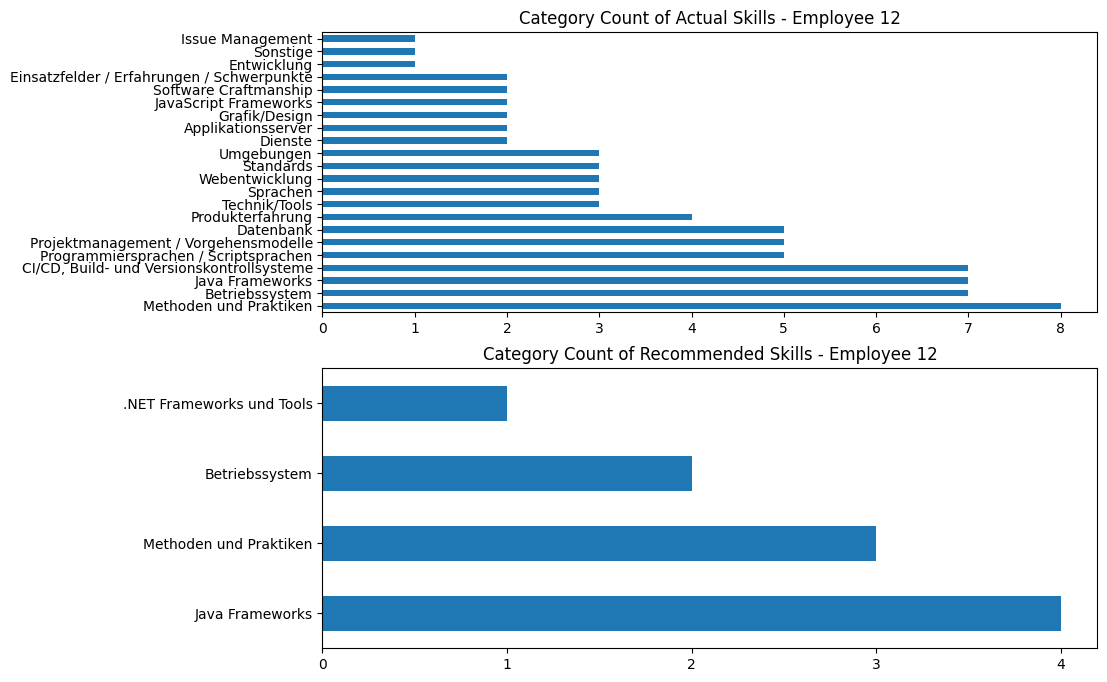

In [45]:
evaluate_employee_recoms(12,10)

Baseline Recommendations: 

In [46]:
baseline = BaselineOnly()
baseline.fit(trainset)
baseline_preds = baseline.test(trainset.build_anti_testset())

Estimating biases using als...


In [47]:
baseline_recommendations = get_recommendations(baseline_preds,10)
baseline_recommendations

,0,1,2,3,4,5,6,7,8,9
12,Jakarta Commons,TestNG,EJB 3,Struts 2,Vue.js,JSF,TopLink,Xerces,RxJS,Servlet/JSP
13,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
15,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
16,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Log4J,JSF,TopLink,Spring
17,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
...,...,...,...,...,...,...,...,...,...,...
1467,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
1474,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
1475,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink
1479,Jakarta Commons,TestNG,Hibernate,EJB 3,Struts 2,JDBC,Vue.js,Log4J,JSF,TopLink


In [48]:
precision_at_k(10,holdout,baseline_recommendations) 

0.14163482967207897

In [49]:
weighted_precision_at_k(10,holdout,baseline_recommendations) 

0.075619581484297

Baseline - most often occuring skills 

In [50]:
most_common_skills = list(df["skill"].value_counts().nlargest(10).index)

recom_list = []
for person in range(0,len(persons)):
    recom_list.append(most_common_skills)

baseline_2_recoms = pd.DataFrame(index=persons,columns=np.arange(0,10),data=recom_list)
baseline_2_recoms

,0,1,2,3,4,5,6,7,8,9
12,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
13,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
15,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
16,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
17,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
...,...,...,...,...,...,...,...,...,...,...
1467,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1474,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1475,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL
1479,Englisch,MySQL,SCRUM,GIT,HTML,JavaScript,JIRA,CSS,Java,SQL


In [51]:
precision_at_k(10,holdout,baseline_2_recoms)

0.05924409878564606

In [52]:
weighted_precision_at_k(10,holdout,baseline_2_recoms)

0.012327189551401585

Recommendations for new employee:

In [60]:
def get_recoms_for_new_employee(new_id,skilldict,model):

    all_ids = df_rated["person"].unique()
    all_skills = df_rated["skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in skilldict.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_test = []
    for skill in all_skills:
        try:
            skill_rating = skilldict[skill]
            new_test.append((new_id,skill,skill_rating))
        except KeyError:
            new_test.append((new_id,skill,np.nan))
    
    predictions = model.test(new_test)

    return get_top_n(predictions, n=10)[new_id]

In [61]:
new_id = 8774
new_skills = {
                # "Windows 11":4,
                # "Englisch":4,
                # "Chinesisch (Mandarin)":2,
                "Python":4,
                "MATLAB":2,
                "Java":2,
                "MySQL":3,
                "SQLBase":3,
                "Microsoft SQL Server":3,
                "Google Cloud Platform":2,
                "MongoDB":1,
                "JSON":1,
                "Docker":2,
                "Power BI":3,
                "Postman":2,
                "PowerShell":2,
                "Github actions":2
            }

In [83]:
mu = df_rated.rating.mean()
pu = model.pu
qi = model.qi

In [153]:
new_u = np.zeros([len(skills)])
for i,skill in enumerate(skills):
    try:
        new_u[i] = new_skills[skill]
    except KeyError:
        new_u[i] = 0

In [154]:
new_u.shape

(735,)

In [175]:
np.matmul(pu,qi.T)

array([[3.93780735, 4.00095525, 3.91211137, ..., 2.22724498, 0.67916477,
        3.26513949],
       [3.01004939, 3.0361753 , 3.00473738, ..., 2.35300932, 0.72204905,
        2.83493808],
       [2.03710596, 2.02682985, 1.99665109, ..., 2.13687865, 0.36210875,
        1.48412048],
       ...,
       [5.02628256, 4.95186167, 4.95881764, ..., 2.19796023, 0.97623724,
        3.54543781],
       [2.49596142, 2.51107715, 2.49345881, ..., 1.50172683, 0.67993481,
        1.45671969],
       [3.93761828, 3.92143483, 3.93778251, ..., 2.18934638, 0.48394457,
        4.98332741]])

In [164]:
np.conjugate(np.transpose(qi))

array([[-0.32882401, -0.29315699, -0.31561658, ..., -0.14708443,
        -0.0052979 , -0.51235982],
       [ 0.29138397,  0.32228539,  0.28175206, ..., -0.11395223,
        -0.06031927, -0.0759637 ],
       [-0.26402227, -0.26619082, -0.24010103, ...,  0.20457906,
        -0.07853806, -0.09461639],
       ...,
       [-0.3124827 , -0.33986948, -0.31831634, ..., -0.06101272,
        -0.16673248, -0.35443254],
       [-0.02617619, -0.00708259, -0.0286067 , ...,  0.0889845 ,
        -0.04186809, -0.27924457],
       [ 0.52166477,  0.56937099,  0.54482321, ...,  0.18314957,
        -0.00087283,  0.70295182]])

In [165]:
np.matmul(qi,np.conjugate(np.transpose(qi)))

array([[7.23982927, 7.20693091, 7.21805038, ..., 2.57450339, 0.57936972,
        3.79900816],
       [7.20693091, 7.21702812, 7.19609028, ..., 2.61487173, 0.58377062,
        3.80943735],
       [7.21805038, 7.19609028, 7.21113169, ..., 2.5798629 , 0.58687753,
        3.8126113 ],
       ...,
       [2.57450339, 2.61487173, 2.5798629 , ..., 2.94033951, 0.47823608,
        2.06239979],
       [0.57936972, 0.58377062, 0.58687753, ..., 0.47823608, 0.47269827,
        0.51193865],
       [3.79900816, 3.80943735, 3.8126113 , ..., 2.06239979, 0.51193865,
        5.48641719]])

In [103]:
np.matmul(new_u)

['.NET Compact Framework',
 '.NET Core',
 '.NET Framework',
 '3D-Modellierung',
 'ABAP',
 'ADO.NET',
 'AIX',
 'ARIS',
 'ARIS ITArchitect',
 'AS400',
 'ASP Generalist',
 'ASP.NET',
 'ASP.NET MVC-Framework',
 'ASP.NET WebAPI',
 'AWS',
 'AWS Lambda',
 'Abstract',
 'Access',
 'Accessibility / WCAG',
 'Active Directory',
 'ActiveX',
 'Adobe CC',
 'Adobe Flash',
 'Adobe Illustrator',
 'Adobe InDesign',
 'Adobe Indesign',
 'Adobe Photoshop',
 'Adobe Premiere',
 'Adobe XD',
 'After Effects',
 'Agile Methoden',
 'Ajax',
 'Alexa-Skills',
 'Alpine',
 'Analytics',
 'Android',
 'Android Studio',
 'Anforderungsanalyse',
 'Anforderungsmanagement',
 'Angular (2 und höher)',
 'Angular Generalist',
 'Angular Material',
 'Angular Theming',
 'AngularJS',
 'Animations (transition, @keyframes)',
 'Ansible',
 'Ant',
 'Apache',
 'Apache Derby',
 'Apache JMeter',
 'App UX',
 'AppCode',
 'Apple Mac OS X Server',
 'Aptana',
 'Arabisch',
 'Arch Linux',
 'Arduino C',
 'Aspektorientierte Programmierung (AOP)',
 'As

In [98]:
# new_pu = 
new_u.T.shape

(735,)

In [63]:
get_recoms_for_new_employee(new_id,new_skills,model)

[('Windows NT/2000/XP', 2.6511953721697474),
 ('MAC OS X', 2.6511953721697474),
 ('Windows 7', 2.6511953721697474),
 ('Windows 8', 2.6511953721697474),
 ('iOS', 2.6511953721697474),
 ('Android', 2.6511953721697474),
 ('PostgreSQL', 2.6511953721697474),
 ('MySQL', 2.6511953721697474),
 ('LDAP', 2.6511953721697474),
 ('Microsoft Access', 2.6511953721697474)]

In [64]:
def get_recoms_for_new_employee_retrain(new_id,new_skills,n):
    all_ids = df_rated["person"].unique()
    all_skills = df_rated["skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in new_skills.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_employee_df = pd.DataFrame()
    new_employee_df["skill"] = new_skills.keys()
    new_employee_df["rating"] = new_skills.values()
    new_employee_df["person"] = new_id
    new_employee_df = new_employee_df[["person","skill","rating"]]

    df_rated_new = pd.concat([df_rated,new_employee_df],ignore_index=True)
    # COMMENT: right now this function creates a new rated df. In order for this to retain newly added employees, it needs to overwrite the old df with the new data. 
    # this had to be implemented later on

    new_data = Dataset.load_from_df(df_rated_new,reader)

    model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
    #  COMMENT: right now the best model from the initial gridearch is taken. if the model is indeed to be retrained, it should be executing a new gridsearch and take the best estimator from this one
    trainset = new_data.build_full_trainset()
    model.fit(trainset)

    testset = trainset.build_anti_testset()
    predictions = model.test(testset)

    return get_top_n(predictions, n)[new_id]

In [65]:
get_recoms_for_new_employee_retrain(new_id,new_skills,20)

NameError: name 'best_model_dict' is not defined

Tryout: new user 

In [66]:
u = [1,1,1,1,2,2,2,3,3,3,3]
i = [1,2,3,4,1,2,3,1,2,3,4]
r = [4,1,1,4,1,4,2,2,1,4,5]
tryout = pd.DataFrame()
tryout["user"] = u
tryout["item"] = i
tryout["rating"] = r

reader = Reader(rating_scale=(1,5))
svd_data = Dataset.load_from_df(tryout,reader)

tryout_model = SVD(n_factors=3,biased=False)
trainset = svd_data.build_full_trainset()
tryout_model.fit(svd_data.build_full_trainset())

In [67]:
np.matmul(pu,qi.T)

array([[3.90509804, 4.0031419 , 3.89590478, ..., 3.31712058, 3.04333551,
        3.5025966 ],
       [3.0154003 , 3.01248573, 2.99403733, ..., 2.25117267, 2.46009829,
        2.85586371],
       [2.00382781, 1.90321005, 1.96958269, ..., 1.81477908, 1.89657923,
        2.08925568],
       ...,
       [5.1124327 , 4.89295727, 4.93318362, ..., 4.03406623, 3.84392195,
        4.16964036],
       [2.51162122, 2.48974948, 2.50364344, ..., 1.51184119, 1.84635977,
        1.58224421],
       [3.94297698, 3.96729022, 3.93455462, ..., 4.98427689, 4.98251393,
        4.98109719]])

In [68]:
new_user = [1,4,1,0]

In [69]:
m = tryout_preds[0][2]
m

NameError: name 'tryout_preds' is not defined

In [70]:
qi = tryout_model.qi
pu = tryout_model.pu

In [71]:
qi.T

array([[-0.03346889,  0.05771167,  0.17817861,  0.265113  ],
       [-0.12054497, -0.02936796, -0.083132  , -0.32825742],
       [ 0.09205454,  0.04985945, -0.00438889, -0.02108911]])

In [72]:
pu

array([[ 0.19704376, -0.10480819,  0.10479769],
       [-0.04853342, -0.02147583,  0.0128871 ],
       [ 0.26222165, -0.15514592, -0.01476273]])

In [73]:
np.matmul(pu,qi.T)

array([[ 0.01568637,  0.01967488,  0.04336195,  0.08443284],
       [ 0.00539948, -0.0015277 , -0.00691885, -0.00608902],
       [ 0.00856682,  0.01895351,  0.05968467,  0.1207575 ]])

In [74]:
qi.shape

(4, 3)

In [75]:
model?

Type:        SVD
String form: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001E178BC2B30>
File:        c:\users\niels.siepe\envs\ds_ap\lib\site-packages\surprise\prediction_algorithms\matrix_factorization.cp310-win_amd64.pyd
Docstring:  
The famous *SVD* algorithm, as popularized by `Simon Funk
<https://sifter.org/~simon/journal/20061211.html>`_ during the Netflix
Prize. When baselines are not used, this is equivalent to Probabilistic
Matrix Factorization :cite:`salakhutdinov2008a` (see :ref:`note
<unbiased_note>` below).

The prediction :math:`\hat{r}_{ui}` is set as:

.. math::
    \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u

If user :math:`u` is unknown, then the bias :math:`b_u` and the factors
:math:`p_u` are assumed to be zero. The same applies for item :math:`i`
with :math:`b_i` and :math:`q_i`.

For details, see equation (5) from :cite:`Koren:2009`. See also
:cite:`Ricci:2010`, section 5.3.1.

To estimate all the unknown, we minimize the following regul

In [76]:
np.array([np.matmul(new_user,qi)])

array([[ 0.37555641, -0.32114882,  0.28710344]])

In [77]:
pu_new = np.concatenate([pu,np.array([np.matmul(new_user,qi)])],axis=0)
pu_new

array([[ 0.19704376, -0.10480819,  0.10479769],
       [-0.04853342, -0.02147583,  0.0128871 ],
       [ 0.26222165, -0.15514592, -0.01476273],
       [ 0.37555641, -0.32114882,  0.28710344]])

In [78]:
m + np.matmul(qi.T,pu_new)

array([[533077.88475819, 533077.63735079, 533077.81858752],
       [533077.5804613 , 533077.87944867, 533077.64183891],
       [533077.7545147 , 533077.74460161, 533077.75216648]])

In [79]:
pu_new.shape

(4, 3)

https://www.d.umn.edu/~mhampton/m4326svd_example.pdf

To do: 
p-reihe für neuen nutzer erstellen: A = p*qi.T, analog dazu ist für eine reihe (=ein user) x = x_p*qi.T, durch umstellen erhält man x_p = x*qi.T^(-1).
1. x-array für neuen nutzer erstellen: shape 1x724 mit rating an den jeweiligen stellen und sonst 0 values. damit dann mit der umgestellten gleichung x_p erzeugen. 
<br>
wenn wir x_p haben kann man die ersten ratings erzeugen mit r_u,i = mü + x_p * q_i. dann die loss function minimieren, so wie in surprise angegeben. hierfür perceptron schreiben? <br>
oder versuchen, pu vom model zu überschrieben? dann testen auf anti testtest. 